# TP 1 : Optimisation sans contrainte

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Exercice 1 (énergie rayonnante d’un corps noir)

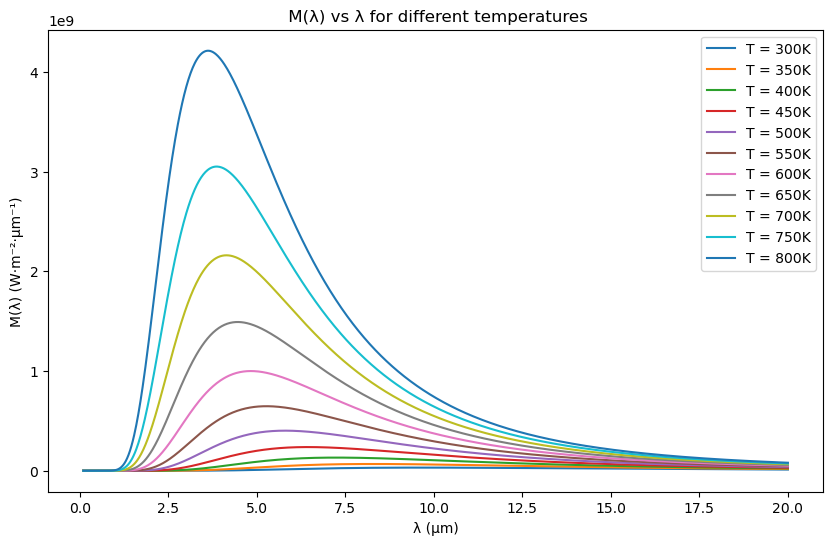

In [27]:
h = 6.625e-34  # Planck
C0 = 2.997e8
k = 1.380e-23  # Boltzmann
n = 1 

lambda_vals = np.linspace(1e-7, 2e-5, 1000)

def M_lambda(lambda_, T):
    numerator = 2 * np.pi * h * C0**2
    denominator = n**2 * lambda_**5 * (np.exp(h * C0 / (n * k * T * lambda_)) - 1)
    return numerator / denominator

T_list = np.arange(300, 801, 50)

plt.figure(figsize=(10, 6))
for T in T_list:
    M_vals = M_lambda(lambda_vals, T)
    plt.plot(lambda_vals * 1e6, M_vals, label=f"T = {T}K")

plt.xlabel("λ (μm)")
plt.ylabel("M(λ) (W·m⁻²·μm⁻¹)")
plt.title(" M(λ) vs λ for different temperatures")
plt.legend()
plt.show()


In [28]:
def golden_section_search(f, a, b, tol=1e-9, max_iter=1000):
    phi = (1 + np.sqrt(5)) / 2
    resphi = 2 - phi
    c = a + resphi * (b - a)
    d = b - resphi * (b - a)
    fc = f(c)
    fd = f(d)
    for i in range(max_iter):
        if abs(b - a) < tol:
            break
        if fc < fd:
            b = d
            d = c
            fd = fc
            c = a + resphi * (b - a)
            fc = f(c)
        else:
            a = c
            c = d
            fc = fd
            d = b - resphi * (b - a)
            fd = f(d)
    return (a + b) / 2

search_a = 1e-7
search_b = 1e-4

lambda_star_values = {}
for T in T_list:
    f = lambda l: -M_lambda(l, T)
    lambda_star = golden_section_search(f, search_a, search_b)
    lambda_star_values[T] = lambda_star

df = pd.DataFrame({
    "T (K)": T_list,
    "λ* (m)": [lambda_star_values[T] for T in T_list]
})

print(df)


    T (K)    λ* (m)
0     300  0.000010
1     350  0.000008
2     400  0.000007
3     450  0.000006
4     500  0.000006
5     550  0.000005
6     600  0.000005
7     650  0.000004
8     700  0.000004
9     750  0.000004
10    800  0.000004


In [29]:
data = []
for T in T_list:
    lam_star = lambda_star_values[T]
    M_max = M_lambda(lam_star, T)
    product = lam_star * T
    ratio = M_max / T**5
    data.append([T, lam_star, product, M_max, ratio])

df = pd.DataFrame(data, columns=[
    "T (K)", "λ* (m)", "λ*T (m·K)", "M(λ*) (W·m⁻²·m⁻¹)", "M(λ*)/T⁵"
])

print(df)

    T (K)    λ* (m)  λ*T (m·K)  M(λ*) (W·m⁻²·m⁻¹)  M(λ*)/T⁵
0     300  0.000010   0.002898       3.124231e+07  0.000013
1     350  0.000008   0.002898       6.752693e+07  0.000013
2     400  0.000007   0.002898       1.316548e+08  0.000013
3     450  0.000006   0.002898       2.372463e+08  0.000013
4     500  0.000006   0.002898       4.017786e+08  0.000013
5     550  0.000005   0.002898       6.470685e+08  0.000013
6     600  0.000005   0.002898       9.997538e+08  0.000013
7     650  0.000004   0.002898       1.491776e+09  0.000013
8     700  0.000004   0.002898       2.160862e+09  0.000013
9     750  0.000004   0.002898       3.051006e+09  0.000013
10    800  0.000004   0.002898       4.212954e+09  0.000013


## Exercice 2 (méthodes de type gradient pour des fonctions quadratiques)

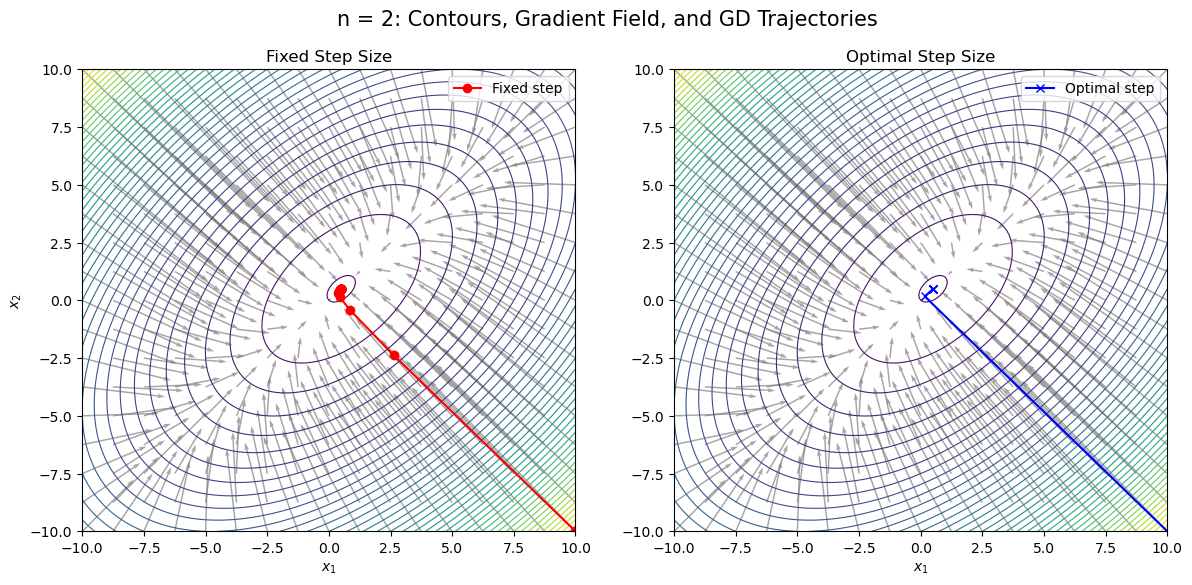

In [30]:
from scipy.sparse import diags

# ---------------- Matrix and Function Definitions ------------------
def A_n(n: int) -> np.ndarray:
    return diags([[-2]*(n-1), [4]*n, [-2]*(n-1)], offsets=[-1, 0, 1]).toarray()

def b_n(n: int) -> np.ndarray:
    return np.ones(n)

def J(A: np.ndarray, b: np.ndarray, x: np.ndarray) -> float:
    return 0.5 * x @ A @ x - b @ x

def gradJ(A: np.ndarray, b: np.ndarray, x: np.ndarray) -> np.ndarray:
    return A @ x - b

# ---------------- Gradient Descent Algorithms ---------------------
def gd_fixed(A, b, x0, s, tol=1e-6, max_iter=50):
    x = x0.copy()
    path = [x.copy()]
    for _ in range(max_iter):
        g = gradJ(A, b, x)
        if np.linalg.norm(g) < tol:
            break
        x -= s * g
        path.append(x.copy())
    return np.array(path)

def gd_optimal(A, b, x0, tol=1e-6, max_iter=50):
    x = x0.copy()
    path = [x.copy()]
    for _ in range(max_iter):
        g = gradJ(A, b, x)
        if np.linalg.norm(g) < tol:
            break
        alpha = (g @ g) / (g @ (A @ g))
        x -= alpha * g
        path.append(x.copy())
    return np.array(path)

# ---------------- Visualization for n = 2 ------------------------
def plot_contours_and_paths():
    n = 2
    A = A_n(n)
    b = b_n(n)
    x0 = np.array([10.0, -10.0])
    s = 1 / 8

    path_fixed = gd_fixed(A, b, x0, s)
    path_opt   = gd_optimal(A, b, x0)

    X = np.linspace(-10, 10, 201)
    Y = np.linspace(-10, 10, 201)
    XX, YY = np.meshgrid(X, Y)
    ZZ = 0.5 * (4*XX**2 - 4*XX*YY + 4*YY**2) - (XX + YY)

    # ──────────────────────────
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.contour(XX, YY, ZZ, levels=40, linewidths=0.8)

    for xi in np.linspace(-10, 10, 17):
        for yi in np.linspace(-10, 10, 17):
            g = gradJ(A, b, np.array([xi, yi]))
            plt.quiver(xi, yi, -g[0], -g[1], scale=200, width=0.003,
                       color='gray', alpha=0.7)

    plt.plot(path_fixed[:, 0], path_fixed[:, 1], 'r-o', label="Fixed step")
    plt.title("Fixed Step Size")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.xlim(-10, 10); plt.ylim(-10, 10)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.contour(XX, YY, ZZ, levels=40, linewidths=0.8)
    for xi in np.linspace(-10, 10, 17):
        for yi in np.linspace(-10, 10, 17):
            g = gradJ(A, b, np.array([xi, yi]))
            plt.quiver(xi, yi, -g[0], -g[1], scale=200, width=0.003,
                       color='gray', alpha=0.7)
    plt.plot(path_opt[:, 0], path_opt[:, 1], 'b-x', label="Optimal step")
    plt.title("Optimal Step Size")
    plt.xlabel(r"$x_1$")
    plt.xlim(-10, 10); plt.ylim(-10, 10)
    plt.legend()

    plt.suptitle("n = 2: Contours, Gradient Field, and GD Trajectories", fontsize=15)
    plt.show()

plot_contours_and_paths()


In [31]:
# ---------------- Benchmarking Function ---------------------------
def is_pos_def(A: np.ndarray) -> bool:
    try:
        np.linalg.cholesky(A)
        return True
    except np.linalg.LinAlgError:
        return False

def benchmark(n_values, fixed_step):
    results = {"n": [], "SPD?": [], "iter_fixed": [], "iter_opt": []}
    for n in n_values:
        A = A_n(n)
        b = b_n(n)
        results["SPD?"].append(is_pos_def(A))
        x0 = np.zeros(n)
        pf = gd_fixed(A, b, x0, fixed_step, tol=1e-8, max_iter=10000)
        po = gd_optimal(A, b, x0, tol=1e-8, max_iter=10000)
        results["n"].append(n)
        results["iter_fixed"].append(len(pf) - 1)
        results["iter_opt"].append(len(po) - 1)
    return results

n_list = [10, 20, 30, 50, 100]
step_fixed = 1 / 8
result = benchmark(n_list, step_fixed)

df = pd.DataFrame({
    "n": result["n"],
    "SPD?": result["SPD?"],
    "Fixed steps": result["iter_fixed"],
    "Optimal steps": result["iter_opt"]
})

print("Benchmark Results:")
print(df)

Benchmark Results:
     n  SPD?  Fixed steps  Optimal steps
0   10  True          954            450
1   20  True         3543           1754
2   30  True         7799           3908
3   50  True        10000          10000
4  100  True        10000          10000


## Exercice 3 (Fonction de Rosenbrock)

1.

$$
\begin{aligned}
\frac{\partial f}{\partial x} &= 2(x - 1) + 20(x^2 - y) \cdot 2x = 2(x - 1) + 40x(x^2 - y) \\
\frac{\partial f}{\partial y} &= -20(x^2 - y)
\end{aligned}
$$

$(x,y)=(1, 1)$

$$
\nabla^2 f = 
\begin{bmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2}
\end{bmatrix}
$$

$$
\nabla^2 f(1,1) =
\begin{bmatrix}
82 & -40 \\
-40 & 20
\end{bmatrix}
$$

In [32]:
H = np.array([[82, -40], [-40, 20]])
cond = np.linalg.cond(H)
print(cond)

258.09612547457573


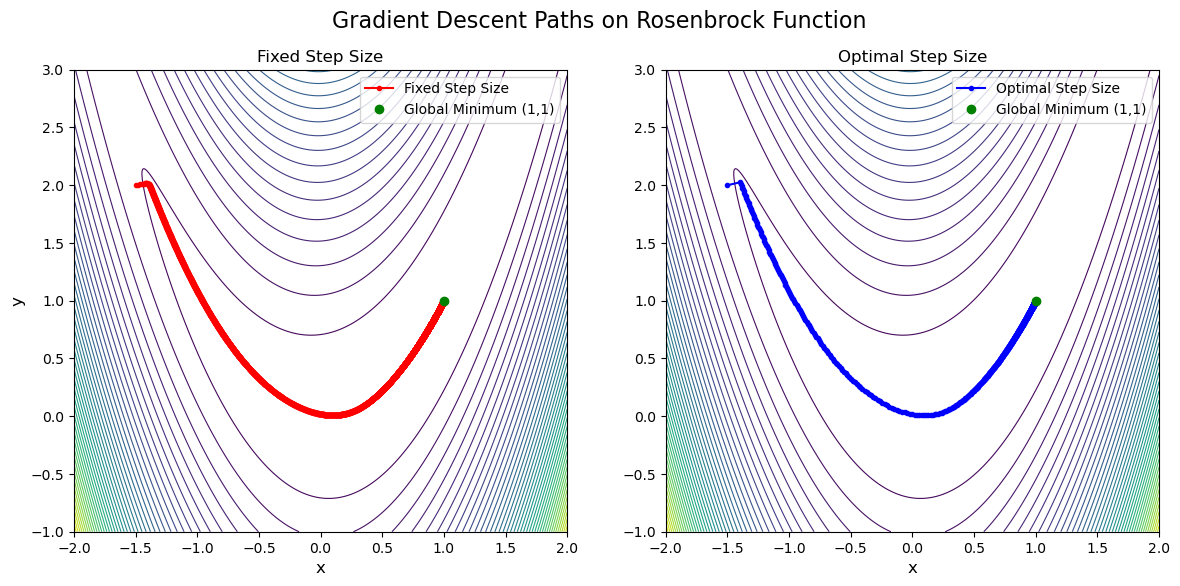

In [34]:
def f(x, y):
    return (x - 1)**2 + 10 * (x**2 - y)**2

def grad_f(xy):
    x, y = xy
    dfdx = 2*(x - 1) + 40*x*(x**2 - y)
    dfdy = -20*(x**2 - y)
    return np.array([dfdx, dfdy])

def gradient_descent(f, grad_f, x0, alpha, max_iter=10000, tol=1e-6, optimal_step=False):
    x = x0.copy()
    path = [x.copy()]
    for _ in range(max_iter):
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        if optimal_step:
            def phi(a): return f(*(x - a * g))
            a_vals = np.linspace(0, 0.01, 100)
            alpha = a_vals[np.argmin([phi(a) for a in a_vals])]
        x = x - alpha * g
        path.append(x.copy())
    return np.array(path)

x0 = np.array([-1.5, 2.0])
path_const = gradient_descent(f, grad_f, x0, alpha=1e-3)
path_opt   = gradient_descent(f, grad_f, x0, alpha=1e-3, optimal_step=True)

x = np.linspace(-2, 2, 500)
y = np.linspace(-1, 3, 500)
XX, YY = np.meshgrid(x, y)
ZZ = f(XX, YY)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.contour(XX, YY, ZZ, levels=50, linewidths=0.8)
plt.plot(path_const[:,0], path_const[:,1], 'r.-', label='Fixed Step Size')
plt.plot(1, 1, 'go', label='Global Minimum (1,1)')
plt.title("Fixed Step Size")
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(fontsize=10)

plt.subplot(1, 2, 2)
plt.contour(XX, YY, ZZ, levels=50, linewidths=0.8)
plt.plot(path_opt[:,0], path_opt[:,1], 'b.-', label='Optimal Step Size')
plt.plot(1, 1, 'go', label='Global Minimum (1,1)')
plt.title("Optimal Step Size")
plt.xlabel('x', fontsize=12)
plt.legend(fontsize=10)

plt.suptitle("Gradient Descent Paths on Rosenbrock Function", fontsize=16)

plt.show()
